<a href="https://colab.research.google.com/github/ShashankS1ngh/ML/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import os
import tarfile
from six.moves import urllib

In [48]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH=os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [49]:
import pandas as pd
def load_housing_data(housing_path="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/"):
  csv_path=os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

In [50]:
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [51]:
import matplotlib.pyplot as plt

In [52]:
import numpy as np
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [53]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


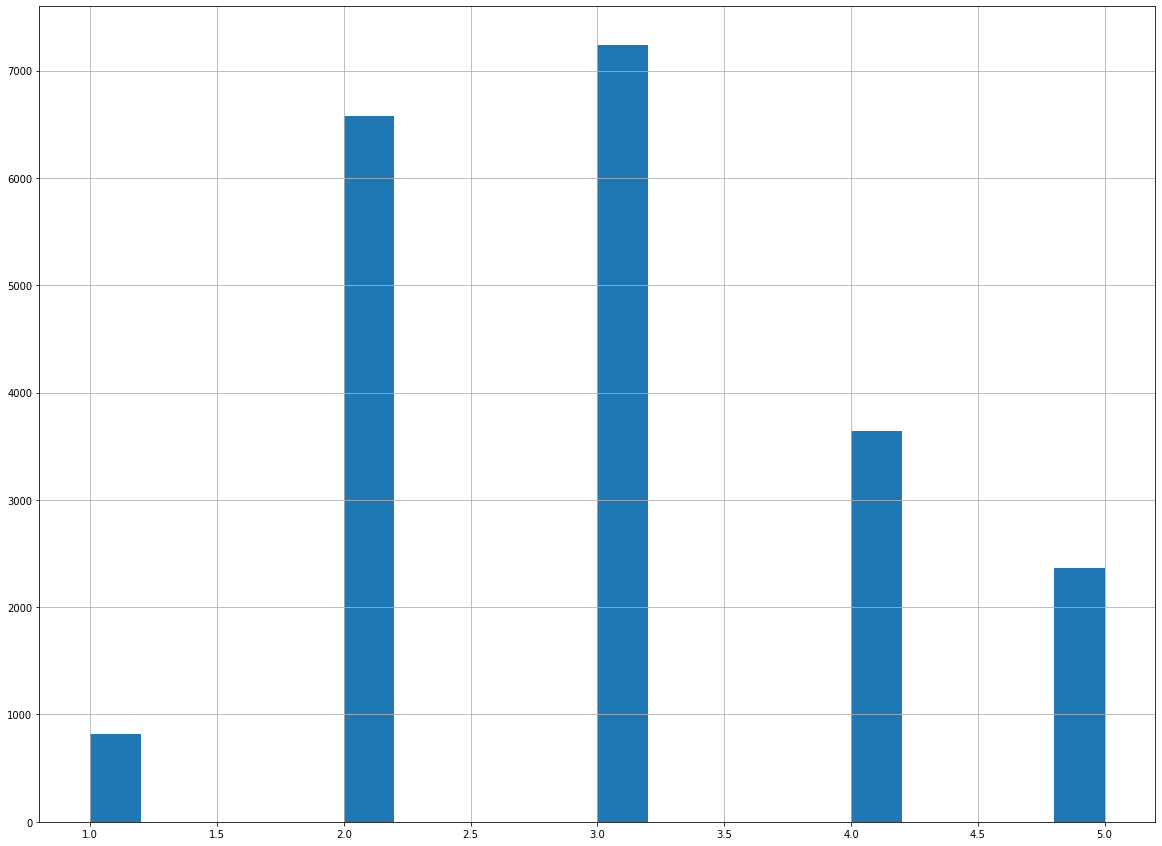

In [54]:
housing["income_cat"]=np.ceil(housing["median_income"]/1.5)
housing["income_cat"].where(housing["income_cat"]<5,5.0,inplace=True)
housing["income_cat"].hist(bins=20,figsize=(20,15))
plt.show()

In [55]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]   

In [56]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [57]:
housing=strat_train_set.copy()

In [58]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [59]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [60]:
housing_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
           ...   
6563     240200.0
12053    113000.0
13908     97800.0
11159    225900.0
15775    500001.0
Name: median_house_value, Length: 16512, dtype: float64

**housing.dropna(subset=["total_bedrooms"]) 
# option 1
housing.drop("total_bedrooms", axis=1) 
# option 2
median = housing["total_bedrooms"].median()
 # option 3
housing["total_bedrooms"].fillna(median, inplace=True)**

In [61]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")
housing_num=housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [62]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [63]:
x=imputer.transform(housing_num)
housing_tr=pd.DataFrame(x,columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [64]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
housing_cat=housing["ocean_proximity"]
housing_cat_encoded=encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

In [65]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [66]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Above 2 steps could be done in a sigle function

In [67]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
   def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
      self.add_bedrooms_per_room = add_bedrooms_per_room
   def fit(self, X, y=None):
      return self # nothing else to do
   def transform(self, X, y=None):
      rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
      population_per_household = X[:, population_ix] / X[:, household_ix]
      if self.add_bedrooms_per_room:
         bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
         return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
      else:
         return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [69]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [70]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

There's no particular method to transform pipeline fit to pandas dataframe so we have to write custom transformer to this task

In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
   def __init__(self, attribute_names):
      self.attribute_names = attribute_names
   def fit(self, X, y=None):
      return self
   def transform(self, X):
      return X[self.attribute_names].values

In [72]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
('selector', DataFrameSelector(num_attribs)),
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)),
('one_hot_encoder', OneHotEncoder(sparse=False))
#('label_binarizer', LabelBinarizer()),
])

In [73]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

In [74]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [75]:
housing_prepared.shape

(16512, 16)

In [76]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [78]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Bad Prediction


In [79]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [80]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [81]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [82]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [83]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())
  
display_scores(tree_rmse_scores)  

Scores: [69991.79875885 66767.93466872 71368.44470925 68656.25325314
 71985.88503996 74494.07008978 72123.59972962 70482.42265111
 76990.57145807 69823.63891161]
Mean: 71268.46192701164
Standard deviation: 2753.482495656766


In [84]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
 scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798344


In [85]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18718.775219296156

In [86]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [87]:
display_scores(forest_rmse_scores)

Scores: [49206.57111011 47636.32943578 49640.64857289 52446.24915507
 49903.12028201 53261.86095403 48580.9253818  47915.864565
 52897.69866797 50120.41975992]
Mean: 50160.96878845671
Standard deviation: 1936.1895863594132


In [88]:
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [89]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [90]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [91]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
 print(np.sqrt(-mean_score), params)

63403.44643403696 {'max_features': 2, 'n_estimators': 3}
55570.24379902027 {'max_features': 2, 'n_estimators': 10}
52724.16659438376 {'max_features': 2, 'n_estimators': 30}
60630.68456088279 {'max_features': 4, 'n_estimators': 3}
53039.14318990953 {'max_features': 4, 'n_estimators': 10}
50558.463390022785 {'max_features': 4, 'n_estimators': 30}
59175.620834532034 {'max_features': 6, 'n_estimators': 3}
52366.92065291736 {'max_features': 6, 'n_estimators': 10}
49781.07162637981 {'max_features': 6, 'n_estimators': 30}
57920.13088273579 {'max_features': 8, 'n_estimators': 3}
51941.72914380248 {'max_features': 8, 'n_estimators': 10}
50068.59353352744 {'max_features': 8, 'n_estimators': 30}
62795.59827458806 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54534.63131673669 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60197.90340710565 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53122.46346117533 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [92]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.92285391e-02, 6.40111321e-02, 4.62431180e-02, 1.87929721e-02,
       1.70822696e-02, 1.97150985e-02, 1.67957665e-02, 3.52610487e-01,
       5.91899538e-02, 1.08737984e-01, 6.37473292e-02, 9.96367545e-03,
       1.45946272e-01, 1.27561651e-04, 2.60125170e-03, 5.20658938e-03])

In [92]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [96]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48037.87994926376